**Libraries**


In [1]:
# Standard Libraries
import os
import numpy as np
import matplotlib.pyplot as plt

# Scikit-Learn Utilities
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold

# TensorFlow and Keras Core Modules
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
    GlobalAveragePooling2D,
    BatchNormalization,
    Rescaling,
    concatenate
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger

# Pretrained Models from Keras Applications
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input

# Data Preparation and Preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


**Mounting Drive & Defining Paths**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_dir = "/content/drive/MyDrive/LungCancer"
print("Contents of LungCancer:", os.listdir(data_dir))

Contents of LungCancer: ['benign', 'squamous_cell_carcinoma', 'adenocarcinoma']


**Data Loading & Preprocessing & Augmentation**

In [4]:
train_dir = "/content/drive/MyDrive/LungCancerSplit/train"
val_dir = "/content/drive/MyDrive/LungCancerSplit/val"
test_dir = "/content/drive/MyDrive/LungCancerSplit/test"

# Training data generator (with augmentations)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,           # Random rotation
    width_shift_range=0.1,       # Horizontal shift
    height_shift_range=0.1,      # Vertical shift
    shear_range=0.1,             # Shear transformation
    zoom_range=0.1,              # Random zoom
    horizontal_flip=True,        # Horizontal flipping
    fill_mode='nearest',         # Filling strategy for new pixels
)



# Validation and Test data generator (no augmentations)
val_test_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
)

# Training generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),     # Resize images to 150x150
    batch_size=32,              # Batch size
    class_mode='categorical',   # Multi-class classification
    shuffle=True                # Shuffle training data
)

# Validation generator
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),     # Resize images to 150x150
    batch_size=32,              # Batch size
    class_mode='categorical',   # Multi-class classification
    shuffle=False               # Do not shuffle validation data
)

# Test generator
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),     # Resize images to 150x150
    batch_size=32,              # Batch size
    class_mode='categorical',   # Multi-class classification
    shuffle=False               # Do not shuffle test data
)

# Display class indices for reference
print("Class Indices:", train_generator.class_indices)

Found 10500 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Found 2250 images belonging to 3 classes.
Class Indices: {'adenocarcinoma': 0, 'benign': 1, 'squamous_cell_carcinoma': 2}


**CNN Model**

In [5]:
# Hyperparameter Placeholders
LEARNING_RATE = 0.0001
DROPOUT_RATE = 0.5
L2_REGULARIZATION = 0.01
BATCH_SIZE = 32
EPOCHS = 50
NUM_CLASSES = 3  

# Define the CNN model
def create_cnn_model():
    model = Sequential([
        # Convolutional and Pooling layers
        Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(L2_REGULARIZATION), input_shape=(150, 150, 3)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(128, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),

        # Flatten the feature maps
        Flatten(),

        # Fully connected layers
        Dense(128, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),
        Dense(64, activation='relu', kernel_regularizer=l2(L2_REGULARIZATION)),
        BatchNormalization(),
        Dropout(DROPOUT_RATE),

        # Output layer for NUM_CLASSES
        Dense(NUM_CLASSES, activation='softmax')
    ])

    return model

# Create the model
cnn_model = create_cnn_model()

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

csv_logger = CSVLogger(
    filename='training_CNN_log_v3.csv',
    append=True
)

callbacks = [early_stopping, lr_scheduler, csv_logger]

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
cnn_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,005,315 (7.65 MB)

 Trainable params: 2,003,971 (7.64 MB)

 Non-trainable params: 1,344 (5.25 KB)

**Train The Model**

In [6]:
# Train the model
cnn_history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


329/329 ━━━━━━━━━━━━━━━━━━━━ 2294s 7s/step - accuracy: 0.7472 - loss: 7.0039 - val_accuracy: 0.3356 - val_loss: 8.5914 - learning_rate: 1.0000e-04
Epoch 2/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 345ms/step - accuracy: 0.8511 - loss: 6.1176 - val_accuracy: 0.9067 - val_loss: 5.4654 - learning_rate: 1.0000e-04
Epoch 3/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 347ms/step - accuracy: 0.8994 - loss: 5.3446 - val_accuracy: 0.9364 - val_loss: 4.7313 - learning_rate: 1.0000e-04
Epoch 4/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 115s 344ms/step - accuracy: 0.9055 - loss: 4.6691 - val_accuracy: 0.9444 - val_loss: 4.1114 - learning_rate: 1.0000e-04
Epoch 5/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 345ms/step - accuracy: 0.9322 - loss: 3.9966 - val_accuracy: 0.9427 - val_loss: 3.5144 - learning_rate: 1.0000e-04
Epoch 6/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 116s 345ms/step - accuracy: 0.9326 - loss: 3.4246 - val_accuracy: 0.9387 - val_loss: 3.0200 - learning_rate: 1.0000e-04
Epoch 7/50
329/329 ━━━━━━━━━━━━━━━━━━━━ 115s 344ms/st

**Training and Validation Plot**

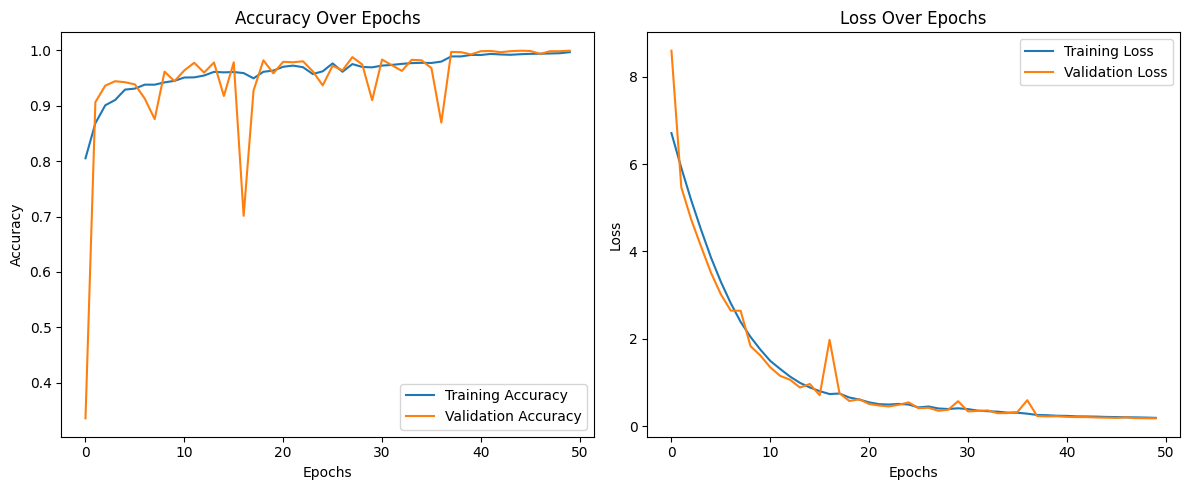

In [7]:
# Plot training and validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['loss'], label='Training Loss')
plt.plot(cnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

**Accuracy On The Test Set (Unseen Data)**

In [8]:
# Evaluate the model
val_loss, val_accuracy = cnn_model.evaluate(test_generator)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 817s 12s/step - accuracy: 0.9992 - loss: 0.1839
Validation Accuracy: 99.91%
Validation Loss: 0.1834


**Save the CNN Model**

In [9]:
# Save the model
cnn_model_save_path = '/content/drive/MyDrive/LungCancer_CNN_model_v3.h5'
cnn_model.save(cnn_model_save_path)
print(f"CNN Model saved to {cnn_model_save_path}")

# Download the model
from google.colab import files
files.download(cnn_model_save_path)

CNN Model saved to /content/drive/MyDrive/LungCancer_CNN_model_v3.h5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>